In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:

path_to_your_folder =  "/content/drive/MyDrive/ML_google_colab/Project 2/ml-project-2-roadmen-bruv" #edit with your own path
%cd $path_to_your_folder

/content/drive/MyDrive/ML_google_colab/Project 2/ml-project-2-roadmen-bruv


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/ML_google_colab/Project 2/ml-project-2-roadmen-bruv/utils")

In [ ]:
PARAMS = {
  'MODELS' : ["Unet","FPN"], # Available : "Unet","DeepLabV3","FPN",
  'ENCODER' : 'resnet34',
  'ENCODER_WEIGHTS' : 'imagenet',
  'NB_EPOCHS' : 2,
  'ACTIVATION' : 'sigmoid', # could be None for logits or 'softmax2d' for multiclass segmentation,
  'DATA_AUGMENTATION' : False, #choose whether the data is augmented to 900 images or use original dataset of 100 images,
  'CLASSES' : ['road'],
}


In [ ]:
from IPython.display import clear_output


In [ ]:

!pip install git+https://github.com/qubvel/segmentation_models.pytorch
!pip install -U albumentations
clear_output()

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils as smp_utils

import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os, sys
import torch
from PIL import Image
import albumentations as albu
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from PIL import Image
import pandas as pd
from save_training_results import save_results





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = [ 'road', 'unlabelled']

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #try using 416 pixels
        image = cv2.resize(image, (416, 416))
        mask = cv2.imread(self.masks_fps[i],0)
        mask = cv2.resize(mask, (416, 416))

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)

In [ ]:


models = [[smp.create_model(model_name, encoder_name=PARAMS["ENCODER"], encoder_weights = PARAMS["ENCODER_WEIGHTS"], in_channels=3, classes=1),model_name] for model_name in PARAMS["MODELS"]]

preprocessing_fn = smp.encoders.get_preprocessing_fn(PARAMS["ENCODER"], PARAMS["ENCODER_WEIGHTS"])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 75.1MB/s]


In [ ]:

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

In [ ]:
# import sys
# sys.path.append('./utils/')
# from data_augmentation import load_img_training, split_keys, store_images, resize_augment_store_dataset

# # Create folders for data augmentation
# %mkdir data/data_train_augmented
# %mkdir data/data_train_augmented/images/
# %mkdir data/data_train_augmented/masks/
# %mkdir data/data_train_augmented/raw/
# %mkdir data/data_train_augmented/raw/images/
# %mkdir data/data_train_augmented/raw/masks/
# %mkdir data/data_validation
# %mkdir data/data_validation/images/
# %mkdir data/data_validation/masks/
# %mkdir data/data_validation/raw/
# %mkdir data/data_validation/raw/images/
# %mkdir data/data_validation/raw/masks/

# # Load images and masks from dataset
# PATH_IMG_TRAIN = "./data/training/images/"
# PATH_MASK_TRAIN = "./data/training/groundtruth/"
# img_train, mask_train = load_img_training(PATH_IMG_TRAIN, PATH_MASK_TRAIN)
# key_list = list(img_train.keys())
# key_list.sort()

# # Split the images for training/validation (+ store)
# training_ratio = 0.8
# seed = 1
# train_keys, val_keys = split_keys(np.array(key_list), training_ratio=training_ratio, seed=seed)

# PATH_TR_IMG_AUG_RAW = "./data/data_train_augmented/raw/images/"
# PATH_TR_MASK_AUG_RAW = "./data/data_train_augmented/raw/masks/"
# PATH_VAL_IMG_RAW = "./data/data_validation/raw/images/"
# PATH_VAL_MASK_RAW = "./data/data_validation/raw/masks/"

# store_images(img_train, train_keys, PATH_TR_IMG_AUG_RAW)
# store_images(mask_train, train_keys, PATH_TR_MASK_AUG_RAW)
# store_images(img_train, val_keys, PATH_VAL_IMG_RAW)
# store_images(mask_train, val_keys, PATH_VAL_MASK_RAW)

# MASK_THRESHOLD = 120
# SIZE_X = 416 #divisible by 32
# SIZE_Y = 416 #divisible by 32
# PATH_TR_IMG_AUG = "./data/data_train_augmented/images/"
# PATH_TR_MASK_AUG = "./data/data_train_augmented/masks/"
# PATH_VAL_IMG = "./data/data_validation/images/"
# PATH_VAL_MASK = "./data/data_validation/masks/"

# # Load validation images and resize
# img_val_raw, mask_val_raw = load_img_training(PATH_VAL_IMG_RAW, PATH_VAL_MASK_RAW)
# keys_val = list(img_val_raw.keys())
# resize_augment_store_dataset(img_val_raw, mask_val_raw, keys_val, SIZE_Y, SIZE_X, MASK_THRESHOLD, PATH_VAL_IMG, PATH_VAL_MASK, augment=False)

# # Load training images, resize and augment using geometric transformation (+ store)
# img_tr_raw, mask_tr_raw = load_img_training(PATH_TR_IMG_AUG_RAW, PATH_TR_MASK_AUG_RAW)
# keys_tr = list(img_tr_raw.keys())
# resize_augment_store_dataset(img_tr_raw, mask_tr_raw, keys_tr, SIZE_Y, SIZE_X, MASK_THRESHOLD, PATH_TR_IMG_AUG, PATH_TR_MASK_AUG, augment=True)

In [ ]:
PATH_TR_IMG_AUG_RAW = "./data/data_train_augmented/raw/images/"
PATH_TR_MASK_AUG_RAW = "./data/data_train_augmented/raw/masks/"
PATH_VAL_IMG_RAW = "./data/data_validation/raw/images/"
PATH_VAL_MASK_RAW = "./data/data_validation/raw/masks/"
PATH_TR_IMG_AUG = "./data/data_train_augmented/images/"
PATH_TR_MASK_AUG = "./data/data_train_augmented/masks/"
PATH_VAL_IMG = "./data/data_validation/images/"
PATH_VAL_MASK = "./data/data_validation/masks/"


#change paths for the training and validation datasets depending on wether we want data augmentation or not
if PARAMS["DATA_AUGMENTATION"]:
  training_path_img = PATH_TR_IMG_AUG
  training_path_mask = PATH_TR_MASK_AUG
  validation_path_img = PATH_VAL_IMG
  validation_path_mask = PATH_VAL_MASK
else:
  training_path_img = PATH_TR_IMG_AUG_RAW
  training_path_mask = PATH_TR_MASK_AUG_RAW
  validation_path_img = PATH_VAL_IMG_RAW
  validation_path_mask = PATH_VAL_MASK_RAW

#create training and validation datasets
train_dataset = Dataset(
    training_path_img,
    training_path_mask,
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=['road'])


valid_dataset = Dataset(
    validation_path_img,
    validation_path_mask,
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=["road"],
)

#create the loaders for both datasets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp_utils.losses.DiceLoss()
metrics = [
    smp_utils.metrics.IoU(threshold=0.5),
    smp_utils.metrics.Fscore(),
]

Unet

Epoch: 0
train:   0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


valid:   0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


valid: 100%|██████████| 16/16 [00:03<00:00,  4.90it/s, dice_loss - 0.7779, iou_score - 0.2006, fscore - 0.3271]
{'dice_loss': 0.7778791226446629, 'iou_score': 0.20060122746508569, 'fscore': 0.32708658208139246}
Model saved!

Epoch: 1
valid: 100%|██████████| 16/16 [00:00<00:00, 24.57it/s, dice_loss - 0.2997, iou_score - 0.4726, fscore - 0.6265]
{'dice_loss': 0.2997192032635212, 'iou_score': 0.4726314232684672, 'fscore': 0.6265301111852751}
Model saved!
test
FPN

Epoch: 0
valid: 100%|██████████| 16/16 [00:00<00:00, 23.68it/s, dice_loss - -0.5974, iou_score - 0.7685, fscore - 0.8671]
{'dice_loss': -0.5974319726228713, 'iou_score': 0.7684718705713749, 'fscore': 0.8671017885208131}
Model saved!

Epoch: 1
valid: 100%|██████████| 16/16 [00:01<00:00, 12.30it/s, dice_loss - -0.8321, iou_score - 0.771, fscore - 0.8696]
{'dice_loss': -0.8321384862065314, 'iou_score': 0.7710093408823013, 'fscore': 0.8695741929113865}
Model saved!
test


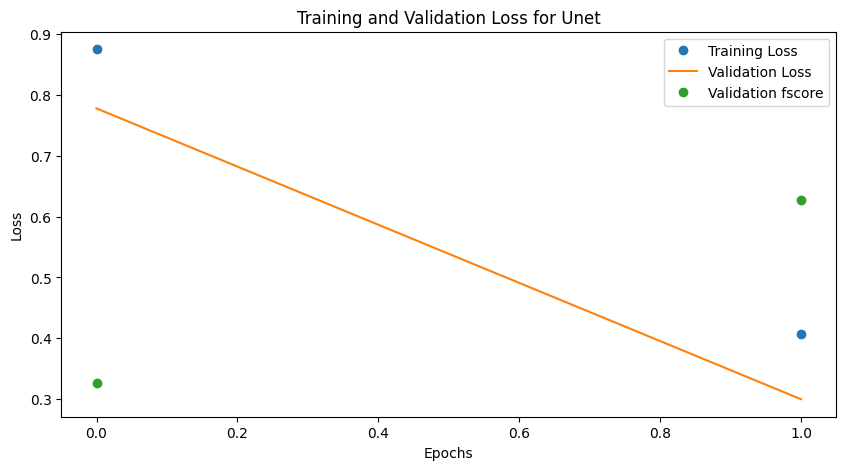

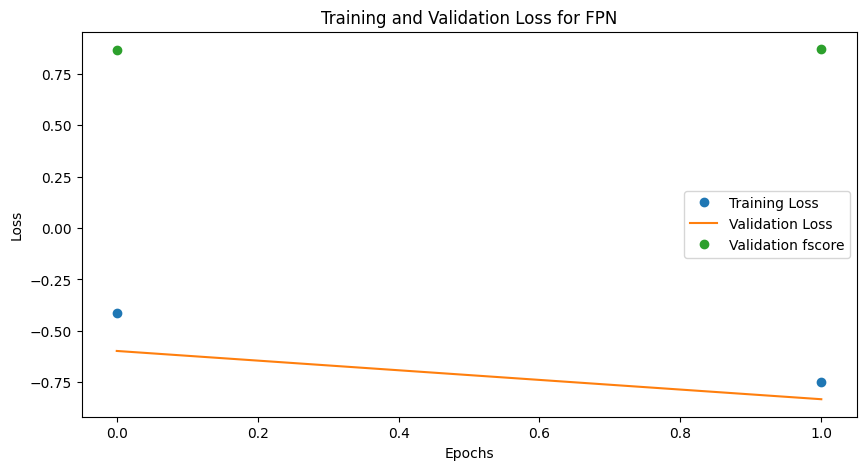

In [ ]:
# train model for NB_EPOCHS



for model,model_name in models:
  print(model_name)
  optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

  train_epoch = smp.utils.train.TrainEpoch(
      model,
      loss=loss,
      metrics=metrics,
      optimizer=optimizer,
      device="cuda",
      verbose=True,
  )

  valid_epoch = smp.utils.train.ValidEpoch(
      model,
      loss=loss,
      metrics=metrics,
      device="cuda",
      verbose=True,
  )


  max_score = 0
  train_loss_array = []
  validation_loss_array = []
  validation_fscore_array = []



  for i in range(0, PARAMS["NB_EPOCHS"]):

      print('\nEpoch: {}'.format(i))
      train_logs = train_epoch.run(train_loader)
      valid_logs = valid_epoch.run(valid_loader)

      train_loss_array.append(train_logs["dice_loss"])
      validation_loss_array.append(valid_logs["dice_loss"])
      validation_fscore_array.append(valid_logs["fscore"])
      print(valid_logs)
      # do something (save model, change lr, etc.)
      if max_score < valid_logs['iou_score']:
          max_score = valid_logs['iou_score']
          torch.save(model, './data/best_model_{}.pth'.format(model_name))
          print('Model saved!')

      if i == 25:
          optimizer.param_groups[0]['lr'] = 1e-5
          print('Decrease decoder learning rate to 1e-5!')
  epochs = range(0,len(train_loss_array))

  save_results(PARAMS,train_loss_array,validation_loss_array,validation_fscore_array)


  plt.figure(figsize=(10, 5))
  plt.plot(epochs, train_loss_array,"o", label='Training Loss')
  plt.plot(epochs, validation_loss_array,  label='Validation Loss')
  plt.plot(epochs, validation_fscore_array, "o" ,  label='Validation fscore')
  plt.title('Training and Validation Loss for {}'.format(model_name))
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()





# II) Visualization & Submission (Not working yet adding

---



In [22]:
# Instantiate your model
# IF YOU TRAINED IT ON GPU, HAS TO BE LOADED ON GPU
gpu = True
cpu = False
MODEL_PATH = "data/best_model_Unet.pth"
if gpu:
  DEVICE = 'cuda'
  # model = FPN_function(ENCODER,ENCODER_WEIGHTS,CLASSES,ACTIVATION,DEVICE)
  # state_dict = torch.load(MODEL_PATH)
  test_model = torch.load(MODEL_PATH)
# if cpu:
#   DEVICE = 'cpu'
#   model = FPN_function(ENCODER, ENCODER_WEIGHTS, CLASSES, ACTIVATION, DEVICE)
#   state_dict = torch.load(MODEL_PATH, map_location=DEVICE)

# model.load_state_dict(state_dict)

# Put the model in evaluation mode
test_model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

### Test

In [23]:
test_dataset = Dataset(
    images_dir="./data/test_set_images/",
    preprocessing= get_preprocessing(preprocessing_fn),
    classes=['road'])

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

#not working for me already had this problem. was dataset class already modified


TypeError: ignored

### Visualization

In [ ]:


# Assuming test_loader is an instance of DataLoader using the Dataset class without masks
batch = next(iter(test_loader))
with torch.no_grad():
    test_model = test_model.to(DEVICE)
    test_model.eval()
    logits = test_model(batch[1].to(DEVICE))  # Ensure you move your inputs to the device where your model is
    pr_gts = logits.sigmoid()

for img_fp, pr_gt in zip(batch, pr_gts):
    img_fp = img_fp[0]
    print(img_fp)
    img = cv2.imread(img_fp)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (416, 416))

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img)  # No need to transpose axes since img is read with cv2 and already in HWC format
    plt.title("Image")
    plt.axis("off")

    # Convert the GPU tensor to CPU and then to a NumPy array before displaying
    plt.subplot(1, 2, 2)
    pr_gt_cpu = pr_gt.cpu().numpy().squeeze()  # Move to CPU and convert to NumPy
    pr_gt_cpu[pr_gt_cpu >= 0.6] = 1
    pr_gt_cpu[pr_gt_cpu < 0.6] = 0
    plt.imshow(pr_gt_cpu, cmap='gray')  # Show the prediction
    plt.title("Prediction")
    plt.axis("off")

    plt.show()


In [ ]:
print(pr_gt_cpu)
plt.hist(pr_gt_cpu.flatten(), bins=10, color='blue', alpha=0.7)

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import os

# Ensure the model is on the correct device and in evaluation mode
test_model = test_model.to(DEVICE)
test_model.eval()
img_nbr = 3
i = 0
# Iterate over all batches in the test_loader
for batch in test_loader:
    i += 1
    with torch.no_grad():
        # Move input to the device where the model is
        input_tensors = batch[1].to(DEVICE)
        logits = test_model(input_tensors)
        pr_gts = logits.sigmoid()

        # Since there are no ground truth masks, we only visualize the images and predictions
        for img_fp, pr_gt in zip(batch[0], pr_gts):  # batch[0] should contain the file paths
            print(img_fp)
            img = cv2.imread(img_fp)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (416, 416))

            # Get the prediction as a numpy array
            pr_gt_np = pr_gt.cpu().numpy().squeeze()

            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(img)  # No need to transpose axes since img is read with cv2 and already in HWC format
            plt.title("Image")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.imshow(pr_gt_np, cmap='gray')  # Show the prediction
            plt.title("Prediction")
            plt.axis("off")

            plt.show()
    if i == img_nbr:
      break


In [ ]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image, to_tensor
from PIL import Image

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_model = test_model.to(DEVICE)
foreground_threshold = 0.6  # Threshold for determining foreground vs background

# Parameters for saving images
output_folder = './submissions/submission_test_5/eval_imgs/'
os.makedirs(output_folder, exist_ok=True)

# Iterate over the DataLoader
for i, (path, image) in enumerate(test_loader):
    # print("Processing image:", i)
    path = path[0]
    with torch.no_grad():
        test_model.eval()
        # Move input to the device
        input_tensor = image.to(DEVICE)
        logits = test_model(input_tensor)
        # Apply sigmoid to get probabilities
        probabilities = torch.sigmoid(logits)
        # Squeeze to remove unnecessary dimensions
        probabilities = probabilities.squeeze(0).squeeze(0)
        # Apply threshold to the probabilities to binarize
        prediction_binarized = (probabilities < foreground_threshold).float()

        # Convert the binarized prediction to a PIL image
        prediction_pil = to_pil_image(prediction_binarized)

        # Resize the PIL image to 608x608
        prediction_pil_resized = prediction_pil.resize((608, 608), Image.NEAREST)

        # Save the image
        image_num = path.split('/')[-1].split('_')[-1].split('.')[0]
        image_num = int(image_num)
        filename = "test_eval_" + '%.3d' % image_num + '.png'
        prediction_pil_resized.save(os.path.join(output_folder, filename))
        # print(f"Saved {filename}")


In [ ]:
SUBMISSION_PATH = "./submissions/submission_test_5/"
submission_filename = SUBMISSION_PATH + 'test_submission.csv'
image_filenames = []
for i in range(1, 51):
    # image_filename = 'training/groundtruth/satImage_' + '%.3d' % i + '.png'
    image_filename = SUBMISSION_PATH + 'eval_imgs/test_eval_' + '%.3d' % i + '.png'
    image_filenames.append(image_filename)
masks_to_submission(submission_filename, *image_filenames)
